In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Loading data

In [ ]:
# !rm sample_submission.csv
# !rm train.csv
# !rm test.csv
# !rm -r train
# !rm -r test

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "pawankumarsahu" 
os.environ['KAGGLE_KEY'] = "d31a0337a22086bc134bc5e294389f85"
!kaggle datasets download -d cdeotte/jpeg-melanoma-256x256
!unzip -q jpeg-melanoma-256x256.zip
!rm jpeg-melanoma-256x256.zip

100% 790M/791M [00:09<00:00, 125MB/s]
100% 791M/791M [00:09<00:00, 83.8MB/s]


In [ ]:
!mv /content/train /content/val
!mv /content/train.csv /content/val.csv

In [ ]:
!kaggle datasets download -d cdeotte/jpeg-isic2019-256x256
!unzip -q jpeg-isic2019-256x256.zip
!rm jpeg-isic2019-256x256.zip

 98% 425M/433M [00:03<00:00, 121MB/s]
100% 433M/433M [00:03<00:00, 120MB/s]


# Importing packages

In [ ]:
!pip install efficientnet_pytorch torchtoolbox
import os
import seaborn as sns
from efficientnet_pytorch import EfficientNet
import gc
import datetime
import warnings
import numpy as np
import pandas as pd
from random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchtoolbox.transform as transforms
from torch.optim.optimizer import Optimizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.pyplot import imread
from pylab import *
from albumentations import (Cutout,JpegCompression,ShiftScaleRotate,CenterCrop,RandomRotate90,Flip,VerticalFlip,Blur,RandomContrast,HueSaturationValue,RandomGamma,Rotate,RandomBrightness,HorizontalFlip, Normalize, Resize, Compose, GaussNoise,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, models, transforms
import time
import copy
!pip install timm
import timm
import rangelars_lookahead_ralamb
from rangelars_lookahead_ralamb import *

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=4b9d0a66e25190517071da514343ce8f7c3e83255914e9e73db72b6836e19dba
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 215kB 5.1MB/s 


In [ ]:
def seed_all(seed=8):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  #random.seed(seed)
  torch.backends.cudnn.enabled=False
  torch.backends.cudnn.deterministic=True

seed_all(42)

In [ ]:
warnings.simplefilter('ignore')
torch.manual_seed(42)
np.random.seed(42)

# Csv file

In [ ]:
train_csv = pd.read_csv('/content/train.csv')
train_csv.target=0
train_csv.target[np.where(train_csv.diagnosis=='NV')[0]]=1
val2020_csv = pd.read_csv('/content/val.csv')
val2020_csv.target=0
val2020_csv.target[np.where(val2020_csv.diagnosis=='nevus')[0]]=1
test_csv = pd.read_csv('/content/test.csv')
test_csv['target']=""
test_csv.target=0

In [ ]:
print('train image count--',len(train_csv),'\t test image count--',len(test_csv),'\t val image count--',len(val2020_csv))
train_csv.target.value_counts(normalize=True)

train image count-- 25331 	 test image count-- 10982 	 val image count-- 33126


1    0.50827
0    0.49173
Name: target, dtype: float64

In [ ]:
train_csv.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,1,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,1,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,0,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,1,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,0,14,1022,767


In [ ]:
val2020_csv.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,1,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


# Extra AUG

In [ ]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [ ]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

# Building datasets

In [ ]:
class dataset(Dataset):
  def __init__(self, csv_file, dir_path, phase):
    self.csv_file = csv_file
    self.dir_path = dir_path
    self.phase = phase
    self.transform = get_transforms(self.phase)

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    img_path = os.path.join(self.dir_path, self.csv_file.iloc[idx, 0]+'.jpg')
    image = imread(img_path)
    label = self.csv_file.target.iloc[idx]
    aug_img = self.transform(image=image)
    image = aug_img["image"]
    return image,label

def get_transforms(phase):
  t_list=[]
  if phase=='train' or phase=='test':
    t_list.extend([
                   #RandomBrightness(limit=0.3, p=0.5),
                   Rotate(limit=90, p=0.5),
                   ##RGBShift(r_shift_limit=50, g_shift_limit=30, b_shift_limit=40, p=1),
                   #RandomGamma(gamma_limit=(80,165), p=0.5),
                   HorizontalFlip(p=0.5),
                   VerticalFlip(p=0.5),
                   #Flip(p=0.5),
                   RandomRotate90(p=0.5),
                   ShiftScaleRotate(shift_limit=0.02,scale_limit=(0.95,1.075),p=0.5),
                   #JpegCompression(quality_lower=50, quality_upper=100, p=0.5),
                   #transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
                   Cutout(num_holes=12, max_h_size=2, max_w_size=2, p=0.5),
                   #transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
                   ##HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=30, p=1),
                   #RandomContrast(limit=0.3, p=0.5),
                   RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
                   ])
  t_list.extend([#CenterCrop(height=205, width=205, p=1),
                 #Resize(224, 224, interpolation=1, p=1),    ## 16x16, 64x64 , 128x100
                 Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                 ToTensor()])
  return  Compose(t_list)

In [ ]:
### creating train and test datasets
train_dataset = dataset(train_csv,'/content/train/','train')
test_dataset = dataset(test_csv,'/content/test/','test')
val2020_dataset = dataset(val2020_csv,'/content/val/','val')
dataset_sizes={'train':len(train_dataset),'test':len(test_dataset)}
print(dataset_sizes)

{'train': 25331, 'test': 10982}


In [ ]:
### visualising datasets
a=randint(0,20000)
print("VISUALISING TRAIN DATASET")
for i in range(a,a+10):
  image, label = train_dataset[i]
  print(i,'\t', image.shape,'\t', label)
print("\nVISUALISING TEST DATASET")
b=randint(0,10000)
for i in range(b,b+10):
  image, label = test_dataset[i]
  print(i,'\t', image.shape,'\t', label)
print("\nVISUALISING VAL DATASET")
c=randint(0,30000)
for i in range(c,c+10):
  image, label = val2020_dataset[i]
  print(i,'\t', image.shape,'\t', label)

VISUALISING TRAIN DATASET
15795 	 torch.Size([3, 256, 256]) 	 1
15796 	 torch.Size([3, 256, 256]) 	 0
15797 	 torch.Size([3, 256, 256]) 	 0
15798 	 torch.Size([3, 256, 256]) 	 0
15799 	 torch.Size([3, 256, 256]) 	 0
15800 	 torch.Size([3, 256, 256]) 	 1
15801 	 torch.Size([3, 256, 256]) 	 0
15802 	 torch.Size([3, 256, 256]) 	 0
15803 	 torch.Size([3, 256, 256]) 	 0
15804 	 torch.Size([3, 256, 256]) 	 1

VISUALISING TEST DATASET
860 	 torch.Size([3, 256, 256]) 	 0
861 	 torch.Size([3, 256, 256]) 	 0
862 	 torch.Size([3, 256, 256]) 	 0
863 	 torch.Size([3, 256, 256]) 	 0
864 	 torch.Size([3, 256, 256]) 	 0
865 	 torch.Size([3, 256, 256]) 	 0
866 	 torch.Size([3, 256, 256]) 	 0
867 	 torch.Size([3, 256, 256]) 	 0
868 	 torch.Size([3, 256, 256]) 	 0
869 	 torch.Size([3, 256, 256]) 	 0

VISUALISING VAL DATASET
5390 	 torch.Size([3, 256, 256]) 	 0
5391 	 torch.Size([3, 256, 256]) 	 0
5392 	 torch.Size([3, 256, 256]) 	 0
5393 	 torch.Size([3, 256, 256]) 	 0
5394 	 torch.Size([3, 256, 256]) 	 

# Visualising Batch

In [ ]:
visual_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

0 torch.Size([16, 3, 256, 256]) torch.Size([16])
1 torch.Size([16, 3, 256, 256]) torch.Size([16])
2 torch.Size([16, 3, 256, 256]) torch.Size([16])
3 torch.Size([16, 3, 256, 256]) torch.Size([16])
batch size-- 16
img size-- 256


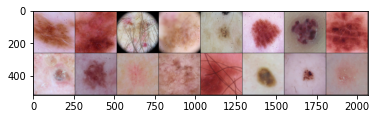

In [ ]:
### visualing batches
def show_batch(sample_batch):
  img_batch,label_batch = sample_batch
  print('batch size--',len(img_batch))
  print('img size--',img_batch.size(2))
  grid_border_size = 2
  grid = torchvision.utils.make_grid(img_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i, sample_batch in enumerate(visual_loader):
  img, label = sample_batch
  print(i, img.size(), label.shape)
  if i==3:
    show_batch(sample_batch)
    break

del img, label, visual_loader 

# Training + prediction

In [ ]:
class Net(nn.Module):
  def __init__(self,arch):
    super(Net,self).__init__()
    self.arch=arch
    num_ftrs = self.arch._fc.in_features
    self.arch._fc = nn.Linear(in_features=num_ftrs, out_features=1, bias=True)
  
  def forward(self,x):
    x = self.arch(x)
    return x

In [ ]:
arch = EfficientNet.from_pretrained('efficientnet-b5')
skf = StratifiedKFold(n_splits=5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


In [ ]:
gc.collect()

0

In [ ]:
#pred_dict = {}
epochs = 6#5#12
model_path='model.pth'
patience = 6#6
tta=11
device = torch.device("cuda")
oof = np.zeros((len(train_csv), 1)) 
oof20 = torch.zeros((len(val2020_dataset),1), dtype=torch.float32, device=device)
preds=torch.zeros((len(test_dataset),1), dtype=torch.float32, device=device)

for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_csv)), y=train_csv['target']), 1):
  print("="*20, 'Fold', fold, '='*20)
  
  best_val = None
  pat = patience
  # if fold<3:
  #   epochs=10
  # else:
  #   epochs=15
  
  model = Net(arch=arch)
  if fold<5:
    model = torch.load('/content/drive/My Drive/nevus1_'+str(fold)+model_path)
  # else:
  # model = torch.load('/content/drive/My Drive/g8_retryagain_new_'+str(fold)+model_path)
  model = model.to(device)
  optim = Ranger(model.parameters(),lr=0.0006)#over9000,0.0006#sgd,0.001#adamw,0.0001,0.001####0.00012,1.92e-7
  scheduler = ReduceLROnPlateau(optimizer=optim, factor=0.2, mode='max', patience=1,verbose=True)#0.2,2
  criterion = nn.BCEWithLogitsLoss()#smoothning

  train = dataset(train_csv.iloc[train_idx].reset_index(drop=True),'/content/train/','train')
  val = dataset(train_csv.iloc[val_idx].reset_index(drop=True),'/content/train/','train')

  train_loader = DataLoader(dataset=train, batch_size=28, shuffle=True, num_workers=4)
  val_loader = DataLoader(dataset=val, batch_size=8, shuffle=False, num_workers=4)
  val2020_loader = DataLoader(dataset=val2020_dataset, batch_size=36,shuffle=False, num_workers=4)
  test_loader = DataLoader(dataset=test_dataset, batch_size=36, shuffle=False, num_workers=4)

  if fold>4:
    for epoch in range(epochs):
      start_time = time.time()
      correct = 0
      epoch_loss = 0
      val_loss = 0
      model.train()
        
      for x,y in train_loader:
        x=torch.tensor(x,device=device, dtype=torch.float32)
        y=torch.tensor(y,device=device, dtype=torch.float32)
        optim.zero_grad()
        z= model(x)
        loss = criterion(z, y.unsqueeze(1))
        loss.backward()
        optim.step()
        pred = torch.round(torch.sigmoid(z))
        correct += (pred.cpu()==y.cpu().unsqueeze(1)).sum().item()
        epoch_loss += loss.item()
      train_acc = correct/len(train_idx)
      
      model.eval()
      val_preds = torch.zeros((len(val_idx),1),dtype=torch.float32, device=device)
      with torch.no_grad():
        for j,(x_val,y_val) in enumerate(val_loader):
          x_val=torch.tensor(x_val, device=device, dtype=torch.float32)
          y_val=torch.tensor(y_val, device=device, dtype=torch.float32)
          z_val = model(x_val)
          val_pred = torch.sigmoid(z_val)
          val_preds[j*x_val.shape[0]:(j+1)*x_val.shape[0]] = val_pred
        val_acc = accuracy_score(train_csv.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
        val_roc = roc_auc_score(train_csv.iloc[val_idx]['target'].values, val_preds.cpu())

        print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
              epoch + 1, 
              epoch_loss, 
              train_acc, 
              val_acc, 
              val_roc, 
              str(datetime.timedelta(seconds=time.time() - start_time))))
        
        scheduler.step(val_roc)
        if not best_val:
          best_val = val_roc
          best_loss=epoch_loss
          torch.save(model, model_path)
          continue
        if epoch_loss<best_loss:
          best_val=val_roc
          best_loss=epoch_loss
          pat=patience
          torch.save(model, model_path)
          print('UPDATED ^')
        # elif (best_val-val_roc)<0.001 and epoch_loss<best_loss:
        #   best_val=val_roc
        #   best_loss=epoch_loss
        #   pat=patience
        #   torch.save(model, model_path)
        #   print('UPDATED ^')
        else:
          pat-=1
          if pat==0:
            print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
            break
    model = torch.load(model_path)
    torch.save(model,'/content/drive/My Drive/nevus1_'+str(fold)+model_path)
  model.eval()
  # val_preds = torch.zeros((len(val_idx),1), dtype=torch.float32, device=device)
  with torch.no_grad():
    # for j, (x_val, y_val) in enumerate(val_loader):
    #   x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
    #   y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
    #   z_val = model(x_val)
    #   val_pred = torch.sigmoid(z_val)
    #   val_preds[j*x_val.shape[0]:j*x_val.shape[0] + x_val.shape[0]] = val_pred
    # oof[val_idx] = val_preds.cpu().numpy()
    if fold>4:
      del x,y
    del  train, val, train_loader, val_loader, x_val,y_val
    
    for i,(x_v,y_v) in enumerate(val2020_loader):
          x_v = torch.tensor(x_v, device=device, dtype=torch.float32)
          z_v = model(x_v)
          z_v = torch.sigmoid(z_v)
          oof20[i*x_v.shape[0]:(i+1)*x_v.shape[0]] += z_v
    del val2020_loader, x_v,y_v

    gc.collect()
    for _ in range(tta):
      for i,(x_test,y_test) in enumerate(test_loader):
        x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
        z_test = model(x_test)
        z_test = torch.sigmoid(z_test)
        preds[i*x_test.shape[0]:(i+1)*x_test.shape[0]] += z_test
    preds/=tta###write code such that for every tta even if we get one true then thats imp
    #pred_dict[str(fold)]=preds
  del x_test,y_test,test_loader
  gc.collect()

preds/= skf.n_splits
oof20 /= skf.n_splits

==================== Fold 1 ====================
Epoch 001: | Loss: 150.592 | Train acc: 0.914 | Val acc: 0.760 | Val roc_auc: 0.857 | Training time: 0:16:24.563116
Epoch 002: | Loss: 88.372 | Train acc: 0.953 | Val acc: 0.760 | Val roc_auc: 0.843 | Training time: 0:16:26.828845
UPDATED ^
Epoch 003: | Loss: 77.130 | Train acc: 0.959 | Val acc: 0.776 | Val roc_auc: 0.860 | Training time: 0:16:27.359609
UPDATED ^
Epoch 004: | Loss: 196.993 | Train acc: 0.887 | Val acc: 0.787 | Val roc_auc: 0.884 | Training time: 0:16:27.506265
Epoch 005: | Loss: 178.582 | Train acc: 0.900 | Val acc: 0.787 | Val roc_auc: 0.885 | Training time: 0:16:26.685846
Epoch 006: | Loss: 163.312 | Train acc: 0.908 | Val acc: 0.761 | Val roc_auc: 0.869 | Training time: 0:16:27.199075
==================== Fold 2 ====================
Epoch 001: | Loss: 172.762 | Train acc: 0.902 | Val acc: 0.872 | Val roc_auc: 0.962 | Training time: 0:16:27.173317
Epoch 002: | Loss: 175.775 | Train acc: 0.902 | Val acc: 0.888 | Val roc

# Final validation score

In [ ]:
# print('OOF: {:.3f}'.format(roc_auc_score(train_csv['target'], oof)))

In [ ]:
print('OOF2020: {:.3f}'.format(roc_auc_score(val_csv['target'], oof20[:,0])))

In [ ]:
# oof_csv = pd.read_csv('train.csv')
# oof_csv['target'] = oof
# oof_csv.to_csv('/content/drive/My Drive/sub_ext_b5_1up_oof.csv', index=False)

In [ ]:
oof20_csv = pd.read_csv('new_train.csv')
oof20_csv['target'] = oof20.cpu()
oof20_csv.target = torch.tensor(oof20_csv.target)[:,0]
oof20_csv.to_csv('/content/drive/My Drive/nevus1_oof.csv')

# Saving csv

In [ ]:
sub_csv = pd.read_csv('sample_submission.csv')
sub_csv['target'] = preds.cpu()

In [ ]:
test_csv.head()

In [ ]:
sub_csv.target= torch.tensor(sub_csv.target)[:,0]

In [ ]:
sub_csv.head()

In [ ]:
sub_csv.to_csv('/content/drive/My Drive/sub_nevus1.csv', index=False)